# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #7
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 23th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Kidney Cancer Data Revisited
In this problem we will work with the US Kidney Cancer Data set (by county). This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

In lecture, we've discussed the potential (and significant) draw backs of drawing conclusions based on raw cancer rates. Addressing these draw backs, we proposed using a Bayesian model to model the data. In the following, you will implement two Bayesian models and examine the adjusted cancer rates per county resulting from these models.

### Part A: Empirical Bayes
Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

(1) Using Empirical Bayes and moment matching, choose appropriate values for the hyperparameters. To do this, consider the **prior-predictive** distribution (also called evidence, the denominator normalization of bayes theorem) of the model: 

$$p(y) = \int p(y \vert \theta) p(\theta) d \theta$$.

(This is as opposed to the posterior predictive: $\int p( y \vert \theta) p(\theta \vert D) d\theta$. Not that in conjugate models such as ours, these two distributions have the same form)

For this model, the prior-predictive is a negative binomial. By matching the mean and the variance of the negative binomial to that from the data you can find $\alpha$ and $\beta$. (Hint: You need to be careful with the $5n_j$ multiplier.) Why the prior-predictive? Because you then "havent seen" individual county data yet.

(2) Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green. 

(**Note:** This is the plot (without the corrected green estimates) shown in the lecture notes for this dataset. We have provided the code to produce this plot, which you are free to use or to ignore.)


(3) Using the scatter plot, explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves.

(**Hint:** You might find it helpful to review the in-class discussion on this dataset. You might also find it helpful to follow the Rat Tumor Baysian model example.)


### Part B: Full Bayes
Rather than estimating the hyperparameters $\alpha, \beta$ from the data, in a full Bayesian model we would put additional priors on quantities of which we are uncertain. That is, we can model the kidney cancer rates using a *hierarchical model*.
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Gamma(a, b)\\
\beta &\sim Gamma(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 


(1) Analytically derive the full conditional, up constants that are inconsequential for sampling, for each variable in the model. 
  
  A possible set of correct final forms of your conditionals looks like the following:
      
\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) &\propto Gamma\left(\theta_j; y_j + \alpha, \beta + 5n_j\right)\\
p(\alpha, \beta | y_j, \theta_j, \sigma^2) &\propto \prod_j\theta_j^{\alpha} \exp\left\{ - \beta\sum_j \theta_j \right\} * Gamma\left(\alpha; a, b \right) * Gamma\left(\beta; c, d \right) \\
\end{aligned}



(2) Implement a Metropolis-Hastings-in-Gibbs sampler (like in rat tumors) to produce sets of theta-values, $\{ \theta_j: j = 1, \ldots, N\}$. Note that for updating some variables, you may need to use a Metropolis-Hastings step (see Rat Tumor example). 

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = \alpha_{\text{emperical bayes}}, \beta_0 = \beta_{\text{emperical bayes}}$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10
  
  We do not guarantee convergence after 100,000 sets of samples under these conditions. In fact, ***convergence in a untweaked sampler maybe unlikely after only 100,000 Gibbs sweeps***. 

  You are responsible for performing your own convergence tests and diagnostics.

  **Note:** to sanity check your implementation, you may wish to implement this model in PyMC3 and compare your results. Note that because you model is hand tuned to deal with the conditionals and to sample straight away from the Gamma's, it will likely run faster)
  
  

- **Extra Credit:** Tweak the settings in your sampler (including number of sweeps) in order to achieve convergence. For example, do you need to sample $\alpha$ and $\beta$ jointly? Can sampling them individually speed up your sampler? Only do this after you have a complete homework. It is a rabbit hole.



(3) Using your samples, produce a pct mortality vs county population scatter plot exactly as in Part A.

In [1]:

import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal
import time

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
from scipy import stats
from scipy.stats import norm, gamma
from scipy.stats import distributions
from scipy.special import gammaln
import scipy

### Part A: Empirical Bayes
Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

(1) Using Empirical Bayes and moment matching, choose appropriate values for the hyperparameters. To do this, consider the **prior-predictive** distribution (also called evidence, the denominator normalization of bayes theorem) of the model: 

$$p(y) = \int p(y \vert \theta) p(\theta) d \theta$$.

(This is as opposed to the posterior predictive: $\int p( y \vert \theta) p(\theta \vert D) d\theta$. Not that in conjugate models such as ours, these two distributions have the same form)

For this model, the prior-predictive is a negative binomial. By matching the mean and the variance of the negative binomial to that from the data you can find $\alpha$ and $\beta$. (Hint: You need to be careful with the $5n_j$ multiplier.) Why the prior-predictive? Because you then "havent seen" individual county data yet.

<font color = "blue">
Since for this model, the prior-predictive is a negative binomial.
$$P( { y }_{ j }=n_{ j } | \theta =\theta _{ j })\quad =\frac { { e }^{ -5n_{ j }\theta _{ j } }(5n_{ j }\theta _{ j })^{ { n }_{ j } } }{ n_{ j } } $$

Since $\theta_j \sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N$
$$f(\theta _{ j })=\frac { \beta ^{ \alpha  } }{ \Gamma (\alpha ) } \theta ^{ \alpha -1 }e^{ -\beta \theta  }$$

Therefore,
$$ \int _{ 0 }^{ \infty  }{ P({ y }_{ j }=n_{ j },\theta  } =\theta _{ j })d\theta _{ j }=\int _{ 0 }^{ \infty  }{ \frac { { e }^{ -5n_{ j }\theta _{ j } }(5n_{ j }\theta _{ j })^{ { n }_{ j } } }{ n_{ j } } \frac { \beta ^{ \alpha  } }{ \Gamma (\alpha ) } \theta _{ j }^{ \alpha -1 }e^{ -\beta \theta _{ j } } } d\theta _{ j }=\frac { \beta ^{ \alpha  }(5n_{ j })^{ n_{ j } } }{ (n_{ j })^{ n_{ j } }\Gamma (\alpha ) } \int _{ 0 }^{ \infty  }{ e^{ -(5n_{ j }+\beta )\theta _{ j } } } \theta _{ j }^{ n_{ j }+\alpha -1 }d\theta _{ j }\\ =\frac { \beta ^{ \alpha  }(5n_{ j })^{ n_{ j } } }{ (n_{ j })^{ n_{ j } }\Gamma (\alpha ) } \frac { \Gamma (n_{ j }+\alpha ) }{ (5n_{ j }+\beta )^{ n_{ j }+\alpha  } } \\ =\frac { \Gamma (n_{ j }+\alpha ) }{ \Gamma (n_{ j }+1)\Gamma (\alpha) } (\frac { \beta  }{ 5n_{ j }+\beta  } )^{ \alpha  }(\frac { 5n_{ j } }{ 5n_{ j }+\beta  } )^{ n_{ j } }$$

Map this equation of negative binomial, we can conclude that prior-predictive is a negative binomial with

$$r = \alpha \quad p = \frac { \beta }{ 5n_{ j }+\beta  } $$

By matching the mean and the variance of the negative binomial to that from the data,

$$E(X_j)=\frac { r(1-p) }{ p } =\frac { 5n_{ j }\alpha  }{ \beta  } $$
$$Var(X_j)=\frac { r(1-p) }{ p^{ 2 } } =\frac { 5n_{ j }\alpha (\beta +5n_{ j }) }{ \beta^2  } $$

Considering the multipier $5n_j$
$$E(\frac{X_j}{5n_j})=\frac { r(1-p) }{ p } =\frac { \alpha  }{ \beta  } $$
$$Var(\frac{X_j}{5n_j})=\frac { r(1-p) }{ p^{ 2 } } =\frac{1}{E(5n_j)}\frac {\alpha }{ \beta }+\frac {\alpha }{ \beta^2  }$$


In [3]:
data_df=pd.read_csv("kcancer.csv")
data_df.head()
#print(data_df.columns)

,state,fips,county,countyfips,dc,pop,pct_mortality
0,ALABAMA,1,AUTAUGA,1001,1.0,64915.0,0.000015
1,ALABAMA,1,BALDWIN,1003,15.0,195253.0,0.000077
2,ALABAMA,1,BARBOUR,1005,1.0,33987.0,0.000029
3,ALABAMA,1,BIBB,1007,1.0,31175.0,0.000032
4,ALABAMA,1,BLOUNT,1009,5.0,91547.0,0.000055


In [4]:
pop = data_df.values[:,5]
N = len(pop)
N

3113

In [5]:
dc = data_df.dc
nj = data_df['pop'].values
#mean_dc_5nj = np.mean(dc/(5*nj))
mean_dc_5nj = np.mean(dc/(5*nj))
var_dc_5nj = np.var(dc/(5*nj))
mean_5nj = 1. /np.mean((5*nj))
beta = mean_dc_5nj/(var_dc_5nj - mean_5nj*mean_dc_5nj)
alpha = beta * mean_dc_5nj

print('Hyperparameter:')
print ('Alpha:',alpha)
print ('Beta:',beta)

Hyperparameter:
Alpha: 1.54517349188
Beta: 133514.171939


(2) Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green. 

(**Note:** This is the plot (without the corrected green estimates) shown in the lecture notes for this dataset. We have provided the code to produce this plot, which you are free to use or to ignore.)


<font color = "blue">


Based on Gamma-Possion, we can get the posterior,
$$ \theta | y_i \sim Gamma ( y_{ i }  + \alpha , 5*n_{ i } +\beta )
$$

In [6]:
# data_df is the dataframe of your data
# estimates is a numpy array of cancer rate estimates, one for each county
def scatter_plot_cancer_rates(data_df, estimates):
    ax = data_df.plot(kind='scatter', x="pop",y="pct_mortality", alpha=0.05, color="grey")
    # NOTE:if you have an older pandas version you should use 
    # "data_df.sort" instead of "data_df.sort_values"
    bot_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=True)[:300]
    top_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=False)[:300]
    top_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="blue", ax=ax, logx=True)
    bot_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="red", ax=ax, logx=True)
    ax.plot(data_df['pop'], 5*estimates, '.', alpha=0.04, color="green")
    ax.set_ylim([-0.0001, 0.0003])

The posterior distribution is:
$$
{ \theta  }_{ j }|{ y }_{ j }∼Gamma(\alpha +{ y }_{ j },\beta +5{ n }_{ j })
$$
The mean is:
$$
E({ \theta  }_{ j }|{ y }_{ j }) = \frac { \alpha +{ y }_{ j } }{ \beta +5{ n }_{ j } } 
$$

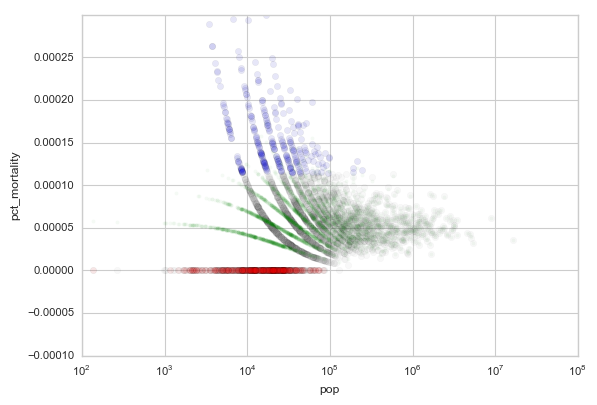

In [8]:
theta_post_mean = np.zeros(N)
for i in range (N):
    theta_post_mean[i] = (alpha + dc[i])/(beta+ 5*nj[i])

scatter_plot_cancer_rates(data_df,theta_post_mean)



(3) Using the scatter plot, explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves.

(**Hint:** You might find it helpful to review the in-class discussion on this dataset. You might also find it helpful to follow the Rat Tumor Baysian model example.)

<font color = "blue">


The key idea here is that some of our units (experiments in our example) are statistically more robust than others. The non-robust experiments may have smaller samples or outlier like behavior, for example. What we wish to do is to borrow strength from all the data as a whole through the estimation of the hyperparameters. In this sense, our procedure will help us create a regularized partial pooling model in which the "lower level" (closer to data) parameter (θs) estimations are tied together by "upper level" parameters.
 
It is hard to estimate rates in counties with low populations. 1 case maybe a rate too low or a rate too high.
Here hierarchical models can also come to the rescue! By assuming that the rates are drawn from a common prior distribution with hyperparameters somehow estimated using all the data, we borrow statistical strength from more populated counties and give it to less populated counties, thus regularizing their rate estimates.

### Part B: Full Bayes
Rather than estimating the hyperparameters $\alpha, \beta$ from the data, in a full Bayesian model we would put additional priors on quantities of which we are uncertain. That is, we can model the kidney cancer rates using a *hierarchical model*.
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Gamma(a, b)\\
\beta &\sim Gamma(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 


(1) Analytically derive the full conditional, up constants that are inconsequential for sampling, for each variable in the model. 
  
  A possible set of correct final forms of your conditionals looks like the following:
      
\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) &\propto Gamma\left(\theta_j; y_j + \alpha, \beta + 5n_j\right)\\
p(\alpha, \beta | y_j, \theta_j, \sigma^2) &\propto \prod_j\theta_j^{\alpha} \exp\left\{ - \beta\sum_j \theta_j \right\} * Gamma\left(\alpha; a, b \right) * Gamma\left(\beta; c, d \right) \\
\end{aligned}



(2) Implement a Metropolis-Hastings-in-Gibbs sampler (like in rat tumors) to produce sets of theta-values, $\{ \theta_j: j = 1, \ldots, N\}$. Note that for updating some variables, you may need to use a Metropolis-Hastings step (see Rat Tumor example). 

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = \alpha_{\text{emperical bayes}}, \beta_0 = \beta_{\text{emperical bayes}}$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10
  
  We do not guarantee convergence after 100,000 sets of samples under these conditions. In fact, ***convergence in a untweaked sampler maybe unlikely after only 100,000 Gibbs sweeps***. 

  You are responsible for performing your own convergence tests and diagnostics.

  **Note:** to sanity check your implementation, you may wish to implement this model in PyMC3 and compare your results. Note that because you model is hand tuned to deal with the conditionals and to sample straight away from the Gamma's, it will likely run faster)
  
  

- **Extra Credit:** Tweak the settings in your sampler (including number of sweeps) in order to achieve convergence. For example, do you need to sample $\alpha$ and $\beta$ jointly? Can sampling them individually speed up your sampler? Only do this after you have a complete homework. It is a rabbit hole.



(3) Using your samples, produce a pct mortality vs county population scatter plot exactly as in Part A.

<font color = "blue">
Since
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Gamma(a, b)\\
\beta &\sim Gamma(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 

To simulate full bayes,

      
$$
p(\theta _{ j }|y_{ j },\mu ,\sigma )=Gamma\left( \theta _{ j };y_{ j }+\alpha ,\beta +5n_{ j } \right) \\ 
p(\alpha ,\beta |y_{ j },\theta _{ j },\sigma ^{ 2 })\propto \prod _{ j } \frac { { \beta  }^{ \alpha  } }{ \Gamma (\alpha ) } \theta _{ j }^{ \alpha }exp\left\{ -\beta \sum _{ j } \theta _{ j } \right\} *Gamma\left( \alpha ;a,b \right) *Gamma\left( \beta ;c,d \right) \\
\quad \propto (\frac { { \beta  }^{ \alpha  } }{ \Gamma (\alpha ) } )^{ N }(\prod _{ j } \theta _{ j }^{ \alpha  })exp\left\{ -\beta \sum _{ j } \theta _{ j } \right\} *Gamma\left( \alpha ;a,b \right) *Gamma\left( \beta ;c,d \right) 
$$

For gibbs sampling step,
Alpha step,
$$
p(\alpha |y_{ j },\beta ,\theta _{ j })\propto (\frac { { \beta  }^{ \alpha  } }{ \Gamma (\alpha ) } )^{ N }\prod _{ j } \theta _{ j }^{ \alpha}*Gamma\left( \alpha ;a,b \right)  
$$

Beta step,
$$p(\beta |y_{ j },\mu ,\theta _{ j })\propto (\frac { { \beta  }^{ \alpha  } }{ \Gamma (\alpha ) } )^{ N }exp\left\{ -\beta \sum _{ j } \theta _{ j } \right\} Gamma\left( \beta ;c,d \right) 
$$


In [7]:
a = 9
b = 6
c = 9
d = 0.00001

<font color = "blue">
### Sampling Jointly

In [8]:

# prior for the hyperparameters
def log_prior(a, b, x):
    if a <= 0 or b <=0:
        return -np.inf
    return a*np.log(b)+(a-1)*np.log(x)-b*x-gammaln(a) 

draw_thetas = lambda a,b: gamma.rvs(dc + a, scale=  1./(5 * nj + b),  size=N)

# conditional posterior (pdf) for alpha and beta
def log_cond_alpha_beta(alpha, beta, theta):
    if alpha <= 0 or beta <=0:
        return -np.inf
    return -N*gammaln(alpha)+N*alpha*np.log(beta)+alpha*np.sum(np.log(theta))-beta*np.sum(theta)+log_prior(a,b,alpha)+log_prior(c,d,beta)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha_beta(alpha, beta, cov, theta, accepts):
    mean = np.array([alpha, beta])
    cov = cov
    astar = np.random.multivariate_normal(mean, cov)  # proposed a new alpha
    num = log_cond_alpha_beta(astar[0], astar[1], theta) 
    den = log_cond_alpha_beta(alpha, beta, theta)
    R = np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return [alpha, beta]

In [14]:
numtraces=1000000
burnin=100000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, N))

cov = np.array([[0.1, 0], [0, 1000]])

alphas[0]=1.
betas[0]=10000
thetas[0,:] = draw_thetas(alphas[0], betas[0])

accepteds={'alpha':0, 'beta':0}

In [15]:
start = time.clock()
for m in np.arange(1, totaltraces):
    a_and_b = draw_alpha_beta(alphas[m-1], betas[m-1], cov, thetas[m-1], accepteds)
    alphas[m] = a_and_b[0]
    betas[m] = a_and_b[1]
    thetas[m, :] = draw_thetas(alphas[m], betas[m])
print("sampling took: ", time.clock()-start, " seconds.")

sampling took:  934.8161349999999  seconds.


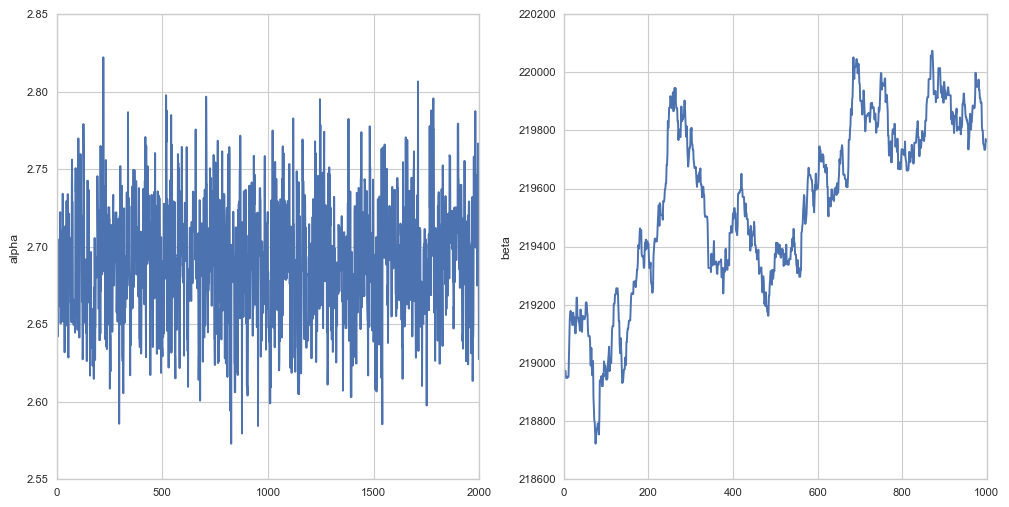

In [13]:
#remove burnin samples and thin
thin=10
alphatrace=alphas[10*burnin+80000:totaltraces:thin]
betatrace=betas[10*burnin+90000:totaltraces:thin]
thetastrace=thetas[burnin+1:totaltraces:thin]
#print(thetastrace.shape, alphatrace.shape)
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphatrace)
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(betatrace)
plt.ylabel('beta')
plt.show()


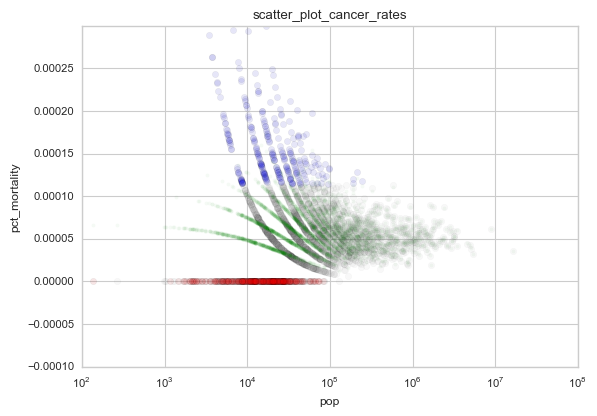

In [51]:
scatter_plot_cancer_rates(data_df,np.mean(thetastrace,axis=0))
plt.title('scatter_plot_cancer_rates')
plt.show()

<font color = "blue">
### Sampling Separately

In [9]:
from scipy.special import gammaln
def logprior_alpha(alpha):
    if alpha <= 0 :
        return -np.inf
    log_prior_alpha = stats.gamma.logpdf(alpha,a,scale=1/b)
    return log_prior_alpha
    
def logprior_alpha_beta(beta):
    if beta <=0:
        return -np.inf
    log_prior_beta = stats.gamma.logpdf(beta,c,scale=1/d)
    return log_prior_beta


    
#draw_thetas = lambda a,b: gamma.rvs(dc + a, scale=  1./(5 * nj + b),  size=N)

def log_cond_alpha(alpha,beta, thetas):
    if alpha <= 0 or beta <=0:
        return -np.inf
    return N*(alpha * np.log(beta) - gammaln(alpha)) + (alpha)*np.sum(np.log(thetas)) + logprior_alpha(alpha)
   
# conditional posterior (pdf) for beta
def log_cond_beta(alpha, beta,  thetas):
    if alpha <= 0 or beta <=0:
        return -np.inf
    return N*(alpha * np.log(beta) - gammaln(alpha)) - beta*np.sum(thetas) + logprior_alpha_beta(beta)

# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(alpha,beta,thetas,proposal_sd_alpha, accepts):
    astar = norm.rvs(alpha,proposal_sd_alpha)  # proposed a new alpha
    num = log_cond_alpha(astar,beta, thetas) 
    den = log_cond_alpha(alpha,beta, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return alpha

def draw_beta(alpha,beta,thetas,proposal_sd_beta, accepts):
    bstar = norm.rvs(beta,proposal_sd_beta)
    num = log_cond_beta(alpha,bstar, thetas)
    den = log_cond_beta(alpha,beta, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den):
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return beta
  


In [10]:

numtraces1=1000000
burnin1=100000
totaltraces1=burnin1+numtraces1

alphas1=np.empty(totaltraces1)
betas1=np.empty(totaltraces1)
thetas1=np.empty((totaltraces1, N))

# these are the step sizes for the proposal distribution
# for our M-H sampling for alpha and beta to be used in Gibbs sampling later
alpha_prop_sd=0.1
beta_prop_sd=1000

#start positions
alphas1[0]=1.
betas1[0]=10000
thetas1[0,:] = draw_thetas(alphas1[0], betas1[0])

#draw_thetas(alphas[0], betas[0])
accepteds1={'alpha':0, 'beta':0}

In [11]:
start = time.clock()

for m in np.arange(1,totaltraces1):
    alphas1[m] = draw_alpha(alphas1[m-1],betas1[m-1],thetas1[m-1,:], alpha_prop_sd, accepteds1)
    betas1[m] = draw_beta(alphas1[m],betas1[m-1],thetas1[m-1,:], beta_prop_sd, accepteds1)
    thetas1[m,:] = draw_thetas(alphas1[m],betas1[m])

print("sampling took: ", time.clock()-start, " seconds.")

sampling took:  1507.1400899999999  seconds.


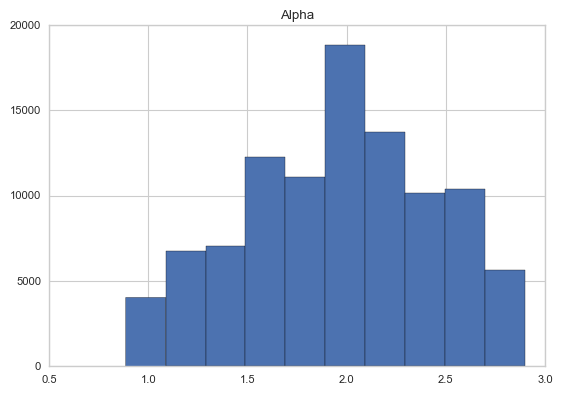

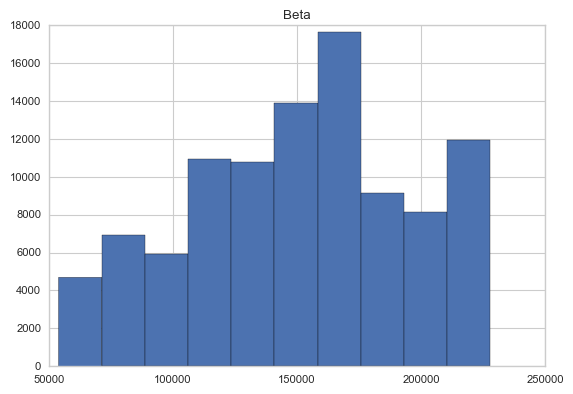

In [57]:
plt.hist(alphatrace1)
plt.title('Alpha')
plt.show()
plt.hist(betatrace1)
plt.title('Beta')
plt.show()

/Users/sunyuting/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


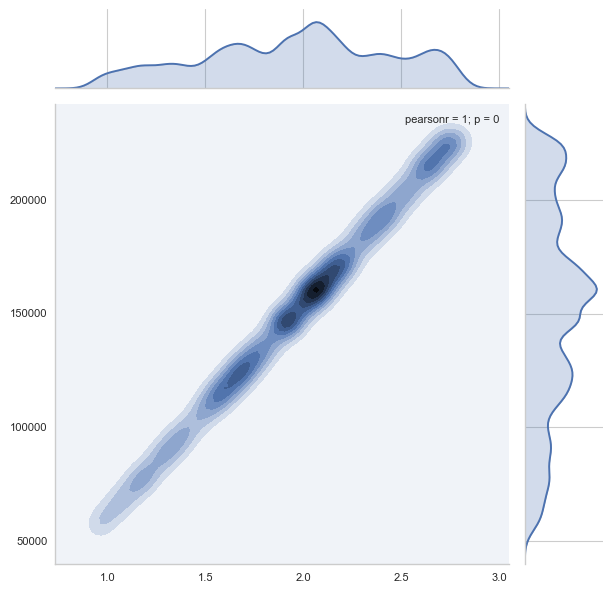

In [59]:
#cmap = sns.cubehelix_palette(light=1, as_cmap=True)
cmaps = [plt.cm.jet]
#plt.hist2d(alphatrace,betatrace, normed=True, bins=100，cmaps=cmaps)
sns.jointplot(x=alphatrace, y=betatrace, kind="kde")
plt.show()

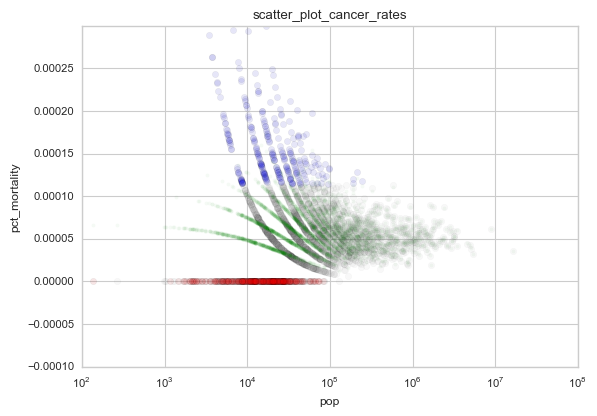

In [60]:
scatter_plot_cancer_rates(data_df,np.mean(thetastrace,axis=0))
plt.title('scatter_plot_cancer_rates')
plt.show()

In [11]:
from pymc3 import Uniform, Normal, Binomial, Beta, sample, Model,Gamma,Poisson # Import relevant distributions

Since health care is an important issue for current society, an increasing  number  of  US  hospitals  have  emerged  among  different  states,  which  support  service in a diverse range of professional fields. This project hopes to help people  decide  which  hospital  is  the  best  choice  depending  on  many  factors 


In [17]:
with pm.Model() as cancer_model:
    # hyper-prior
    hyper_alpha = pm.Gamma('hyper_alpha', alpha=a, beta=b)
    hyper_beta = pm.Gamma('hyper_beta', alpha=c, beta=d)
    
    # parameters
    param_thetas = pm.Gamma('param_thetas',alpha=hyper_alpha,beta=hyper_beta,shape=N)
    y = pm.Poisson('y',mu = 5 * nj * param_thetas, observed=dc)
    # Data likelihood
    #y = pm.Poisson('y', mu=data_n*thetas, observed=data_y)

In [18]:
with cancer_model:
    
    # instantiate sampler
    step = pm.Metropolis()
    ite  = 100000
    # draw 2000 posterior samples
    cancer_trace = pm.sample(ite, step=step)

100%|██████████| 100000/100000 [02:02<00:00, 817.37it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x248760278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x249380080>]], dtype=object)

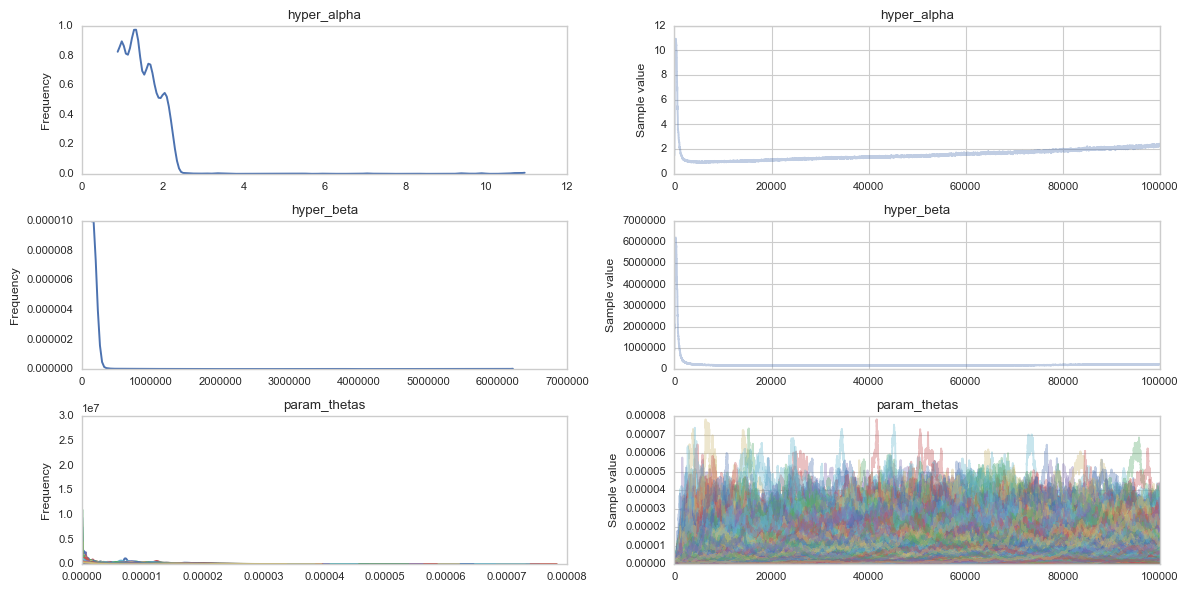

In [20]:
pm.traceplot(cancer_trace[:])

<font color = "blue">
### Summary

Comparing the running duration of the two cases: separate drawing and joint drawing, the former seems run slower than the latter though their results are similar.

Comparing the results using pymc3, it is close to what we got using our own gibbs sampling method.